# Исходные данные

In [1]:
from scipy.integrate import odeint
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numpy import pi, sin
import warnings as w

w.filterwarnings("ignore")

# Давления в каналах
p1 = 400e3
p2_0 = 300e3
p3 = 100e3

# Параметры демпфирующей жидкости
Vд_0 = 0
mд_0 = 0

# Параметры жидкости -> керосин
c = 1330
Vж0 = 0.004
ρж = 820

# Параметры газа -> гелий
k = 1.4
R = 8.314
M = 0.0040026
R_газ = R / M
Tгаз_0 = 293
Vгаз_0 = 0.003

# Коэффициенты инерционности
j1 = j2 = j3 = 400
jд = 20

# Коэффициенты сопротивления
ξ1 = ξ2 = ξ3 = 1000
ξд = 1000

# Решение стационарной задачи

In [2]:
def system_static(vars):
    """ Система уравнений стационарной системы """
    m1_0, m2_0, m3_0, p4_0, pgas_0 = vars
    
    return [m1_0 + m2_0 - m3_0,
            p4_0 - pgas_0,
            p1 - p4_0 - ξ1*m1_0**2,
            p4_0 - p3 - ξ3*m3_0**2,
            p2_0 - p4_0 - ξ2*m2_0**2]


# Вводим начальные приближения
initial_guess = [5, 5, 5, 3e5, 3e5]

# Решение системы
sol_static = fsolve(system_static, initial_guess)

m1_0 = sol_static[0]
m2_0 = sol_static[1]
m3_0 = sol_static[2]
p4_0 = sol_static[3]
pgas_0 = sol_static[4]

rho_газ = pgas_0 / (R_газ * Tгаз_0)
m_газ = rho_газ * Vгаз_0

# Вывод переменных
print("  m1_0 = {:.3f}".format(m1_0))
print("  m2_0 = {:.3f}".format(m2_0))
print("  m3_0 = {:.3f}".format(m3_0))
print("  p4_0 = {:.3f}".format(p4_0))
print("pgas_0 = {:.3f}".format(pgas_0))
print("rho_gas = {:.3f}".format(rho_газ))
print(" m_газ = {:.3f}".format(m_газ))

  m1_0 = 10.515
  m2_0 = 3.249
  m3_0 = 13.764
  p4_0 = 289442.719
pgas_0 = 289442.719
rho_gas = 0.476
 m_газ = 0.001


# Дополнительные функции и константы

In [3]:
# Функции возмущения
def p2(t):
    """ Функция импульсного возмущения """
    if t <= T:
        z = 2 * t * pi/T
        insin = z - pi/2
        p2 = p2_0 + A*sin(insin) + A
    else:
        p2 = p2_0
    return p2


def p2_sin(t):
    """ Функция возмущения, изменяющаяся по синусу """
    z = 2 * t * pi/T
    insin = z - pi/2
    p2 = p2_0 + A*sin(insin)
    return p2


def p2_sin_afc(t, freq):
    """ Функция возмущения, зависящая от частоты """
    insin = freq * 2*pi * t 
    p2 = p2_0 + A*sin(insin)
    return p2


# Функция построения графиков
def plot(t, y, label):
    plt.plot(t, y, label=label)
    plt.grid(True)
    plt.xlabel("$t, с$")
    plt.ylabel(label)
    plt.legend()
    plt.show()


A = 100000  # Амплитуда возмущения
T = 0.1  # Период возмущения

# Временной отрезок моделирования
t_end = .8
h = 1e-6
t = np.arange(0, t_end, h)

# Наборы начальных значений
y0 = [p4_0, Vд_0, m1_0, m2_0, m3_0, mд_0]
y0_n_d = [p4_0, m1_0, m2_0, m3_0]

# Частотный диапазон
frequancy = []
for freq in np.arange(0, 16, 1):
    frequancy.append(freq)
for freq in np.arange(20, 105, 5):
    frequancy.append(freq)
for freq in np.arange(125, 1025, 25):
    frequancy.append(freq)

# Решение динамической задачи с демпфером

## Решение СДУ

In [4]:
def system(y, t):
    """ Система дифференциальных уравнений """
    p4, Vд, m1, m2, m3, mд = y
    
    d_p4 = (m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2)
    d_Vд = mд / ρж
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2(t) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    d_mд = (p4 - (m_газ / (Vгаз_0 - Vд)) * R_газ * 
            (Tгаз_0 * ((p4 / p4_0)**((k-1)/k))) - 
                ξд * mд * abs(mд)) / jд
    
    return [d_p4, d_Vд, d_m1, d_m2, d_m3, d_mд]


# Решение
sol = odeint(system, y0, t)

p_газ = (m_газ / (Vгаз_0 - sol[:, 1])) * R_газ * \
    (Tгаз_0 * ((sol[:, 0] / p4_0)**((k-1)/k)))

In [5]:
max(sol[:, 0])

343719.8998417112

## Построение графиков

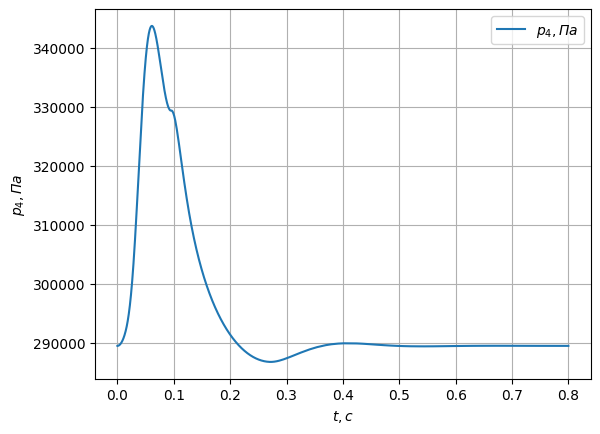

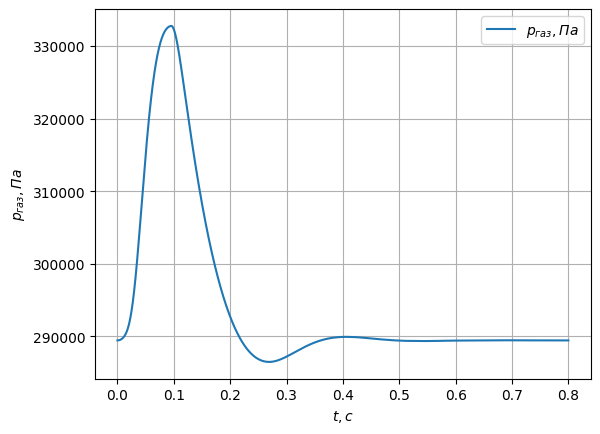

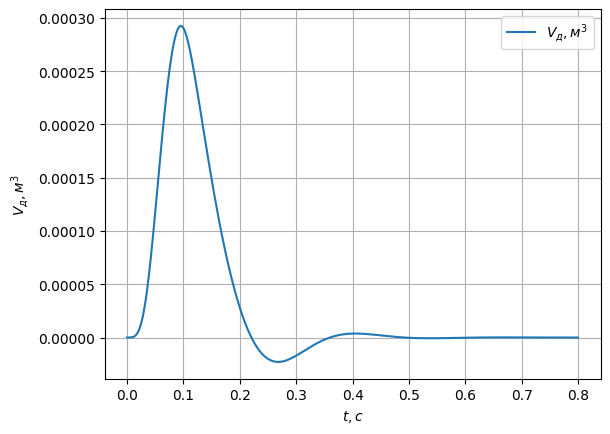

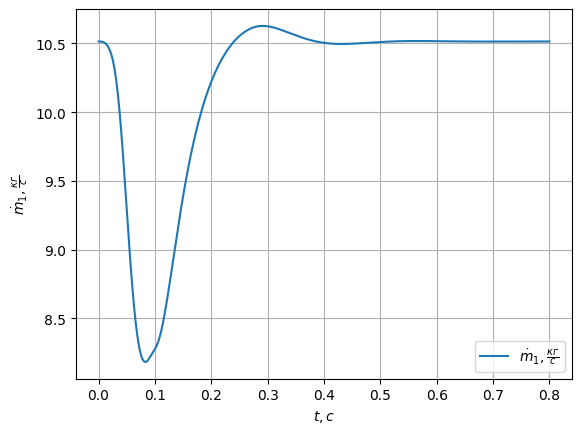

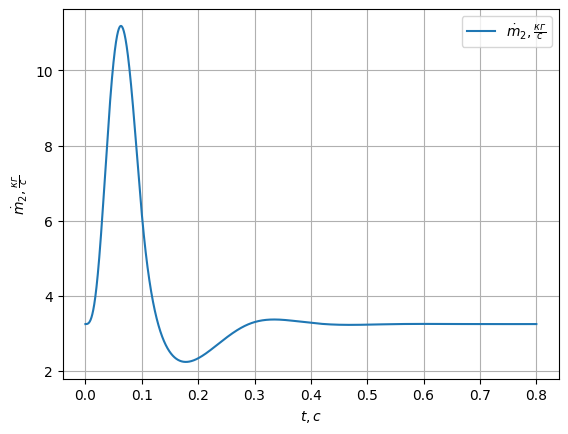

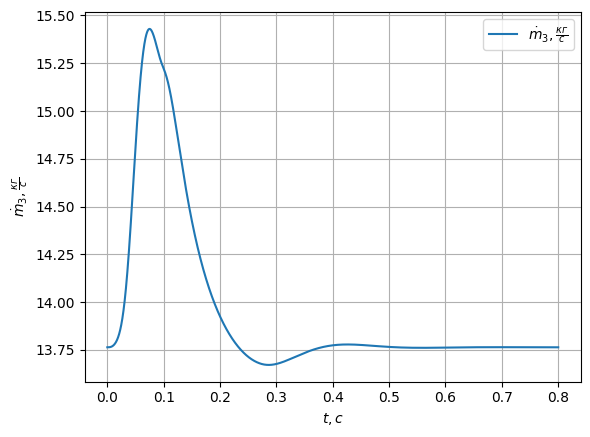

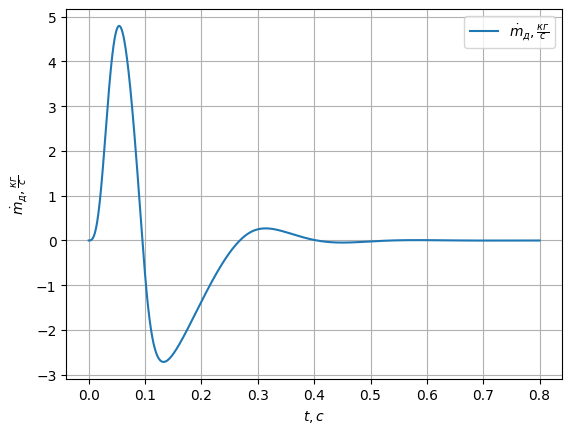

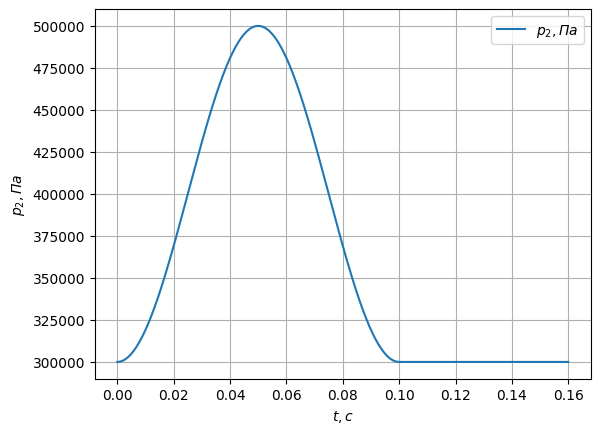

In [6]:
plot(t, sol[:, 0], r"$p_4, Па$")
plot(t, p_газ, r"$p_{газ}, Па$")
plot(t, sol[:, 1], r"$V_д, м^3$")
plot(t, sol[:, 2], r"$\dot{m}_1, \frac{кг}{с}$")
plot(t, sol[:, 3], r"$\dot{m}_2, \frac{кг}{с}$")
plot(t, sol[:, 4], r"$\dot{m}_3, \frac{кг}{с}$")
plot(t, sol[:, 5], r"$\dot{m}_д, \frac{кг}{с}$")
plot(t[:int(t_end//h//5)], [p2(t) for t in t][:int(t_end//h//5)], "$p_2, Па$")

# Построение АЧХ системы с демпфером

## Решение

In [7]:
def system_afc(y, t, freq):
    """ Система дифференциальных уравнений, зависящая от частоты """
    p4, Vд, m1, m2, m3, mд = y
    
    d_p4 = (m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2)
    d_Vд = mд / ρж
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2_sin_afc(t, freq) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    d_mд = (p4 - (m_газ / (Vгаз_0 - Vд)) * R_газ * 
            (Tгаз_0 * ((p4 / p4_0)**((k-1)/k))) - 
                ξд * mд * abs(mд)) / jд
    
    return [d_p4, d_Vд, d_m1, d_m2, d_m3, d_mд]


sol_afc = []
amplitude = []
for i, freq in enumerate(frequancy):
    sol_afc = odeint(system_afc, y0, t, (freq,))
    if i == 15:
        sol_afc_p4_15 = sol_afc[:, 0]
    amplitude.append(
        (max(sol_afc[700000:800000, 0]) - 
         min(sol_afc[700000:800000, 0])) / 2 / A)
    del sol_afc

print(amplitude)

[1.3026874512434006e-12, 0.06228088695108716, 0.2753923471400118, 0.22353512362024922, 0.2807546977430013, 0.283820404097524, 0.23151955356856152, 0.23187528163714452, 0.19846249937144864, 0.1695772899577368, 0.14506765130807267, 0.12454831915860617, 0.10757094109985978, 0.09367080013273837, 0.08238755046523409, 0.07331356297814375, 0.04994781528470892, 0.04678200222969375, 0.049777368684082175, 0.05203616335854284, 0.05353095685463981, 0.05455584935418767, 0.05530126278829761, 0.05590497922743263, 0.056319090966595396, 0.05672409090486908, 0.057001794908168084, 0.05729396836458094, 0.05754571493172203, 0.05775069670969853, 0.05796228375438484, 0.05817437189709075, 0.058889140957427734, 0.059322764873220586, 0.060355983176377775, 0.06153669245705882, 0.06289636631746719, 0.06460430195816094, 0.06637656901459763, 0.06853613894888375, 0.07105967279436445, 0.07406642222734139, 0.07761990101453878, 0.08168647575492767, 0.08659657947472006, 0.09250925216487813, 0.0997181789838968, 0.1086353

## График АЧХ

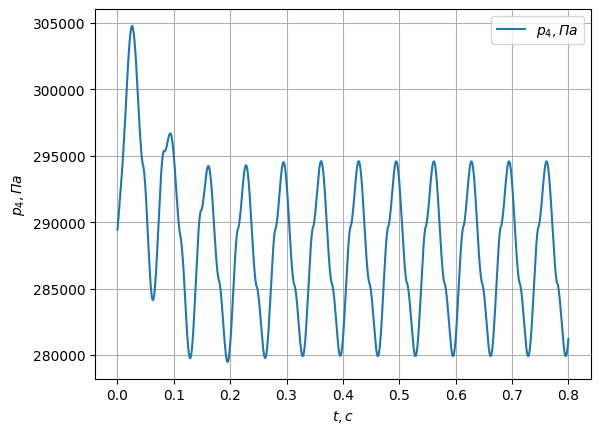

In [8]:
plot(t[:], sol_afc_p4_15[:], "$p_4, Па$")

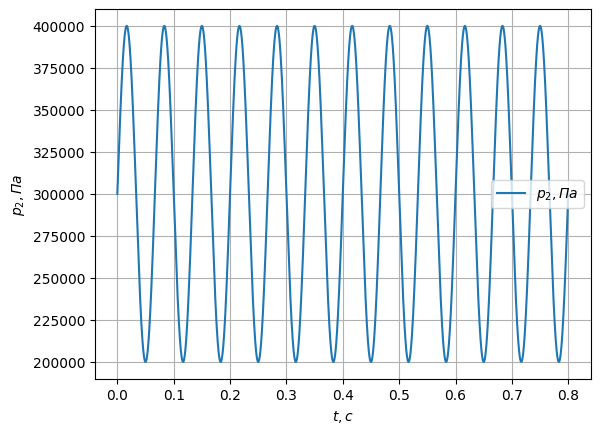

In [9]:
plot(t[:], [p2_sin_afc(t, frequancy[15]) for t in t][:], "$p_2, Па$")

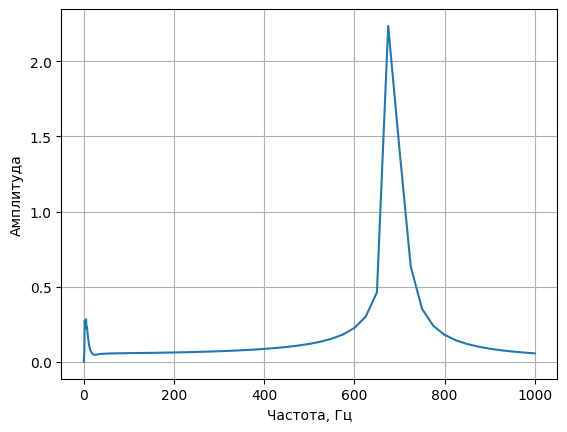

In [10]:
plt.plot(frequancy, amplitude)
plt.grid()
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда")
plt.show()

# Решение динамической задачи без демпфера

## Решение СДУ

In [11]:
def system_no_damper(y, t):
    """ Система дифференциальных уравнений """
    p4, m1, m2, m3 = y
    
    d_p4 = (m1 + m2 - m3) / ((Vж0) / c**2)
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2(t) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    
    return [d_p4, d_m1, d_m2, d_m3]


sol_no_damper = odeint(system_no_damper, y0_n_d, t)

In [12]:
max(sol_no_damper[:, 0])

376204.8683575951

## Построение графиков

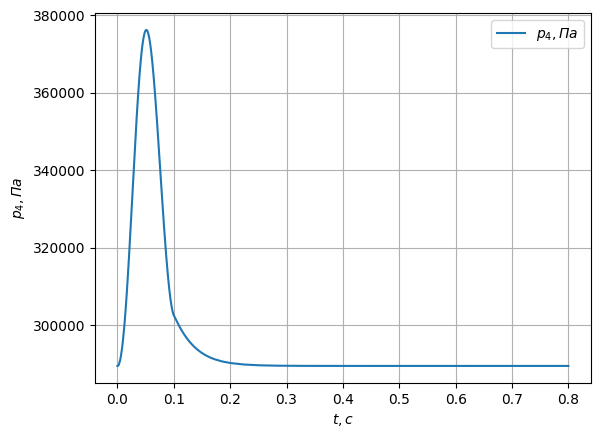

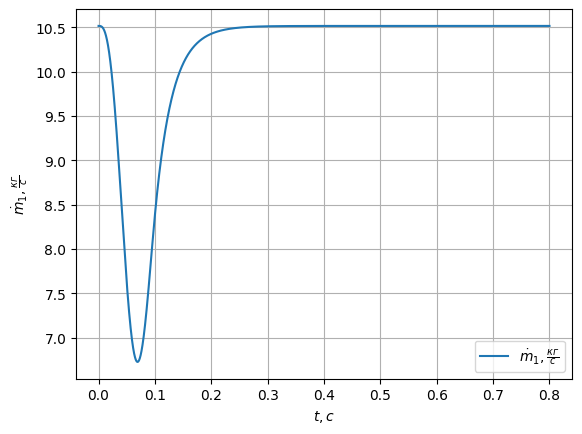

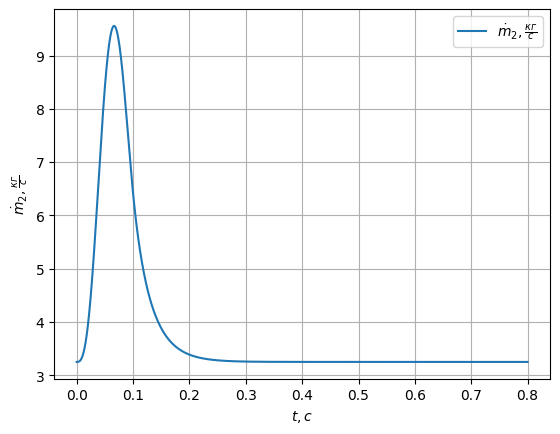

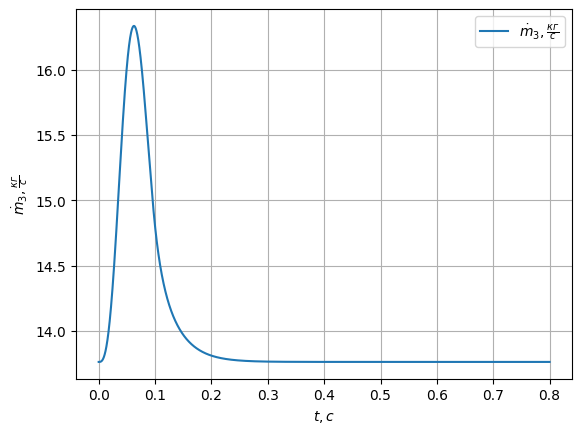

In [13]:
plot(t, sol_no_damper[:, 0], r"$p_4, Па$")
plot(t, sol_no_damper[:, 1], r"$\dot{m}_1, \frac{кг}{с}$")
plot(t, sol_no_damper[:, 2], r"$\dot{m}_2, \frac{кг}{с}$")
plot(t, sol_no_damper[:, 3], r"$\dot{m}_3, \frac{кг}{с}$")

# Построение АЧХ системы без демпфера

## Решение

In [14]:
def system_afc_no_damper(y, t, freq):
    """ Система дифференциальных уравнений """
    p4, m1, m2, m3 = y
    
    d_p4 = (m1 + m2 - m3) / ((Vж0) / c**2)
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2_sin_afc(t, freq) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    
    return [d_p4, d_m1, d_m2, d_m3]


sol_afc_no_damper = []
amplitude_nodamper = []
for i, freq in enumerate(frequancy):
    sol_afc_no_damper = odeint(system_afc_no_damper, y0_n_d, t, (freq,))
    if i == 15:
        sol_afc_nd_p4_15 = sol_afc_no_damper[:, 0]
    amplitude_nodamper.append(
        (max(sol_afc_no_damper[700000:800000, 0]) - 
         min(sol_afc_no_damper[700000:800000, 0])) / 2 / A) 
    del sol_afc_no_damper

print(amplitude_nodamper)

[2.9103830456733706e-16, 0.03379038662401421, 0.3114009849741642, 0.1487726899197692, 0.5259516484201836, 0.34460464933504176, 0.489900499452541, 0.4345199871327447, 0.44647338144947035, 0.42981205982216314, 0.4168487859279958, 0.4059959583305649, 0.397053353904589, 0.38963080733584515, 0.38342485924769426, 0.37820235229665444, 0.361621317861252, 0.3536298297665469, 0.3496258185255596, 0.3477579957115224, 0.34718102368861276, 0.347470301667032, 0.3483968598645326, 0.3498310160569627, 0.35169724673597563, 0.35395150972897405, 0.3565691901693893, 0.3595383804344945, 0.36285599374774363, 0.3665254948527126, 0.3705555175311933, 0.37495909512435815, 0.37975340114293243, 0.41045783577902695, 0.4559956704524858, 0.5251225308255224, 0.6366678686184661, 0.8386401971502049, 1.2985647175920485, 3.253082639504942, 4.386821185321075, 1.2877273930344568, 0.7260050538882533, 0.49410811206914573, 0.36828926205777346, 0.2897336684382567, 0.23627518423975793, 0.19770819480553037, 0.16868399427111638, 0.

## График АЧХ

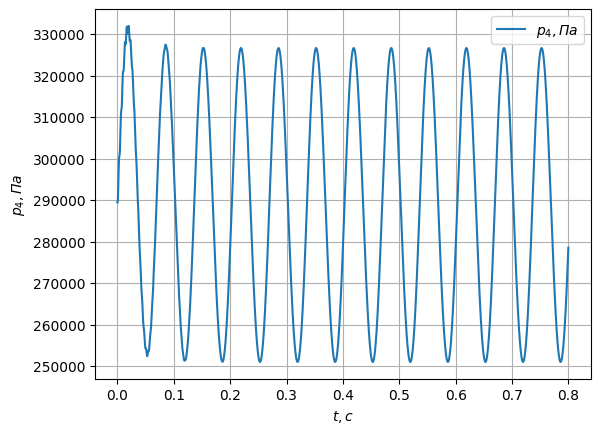

In [15]:
plot(t[:], sol_afc_nd_p4_15[:], "$p_4, Па$")

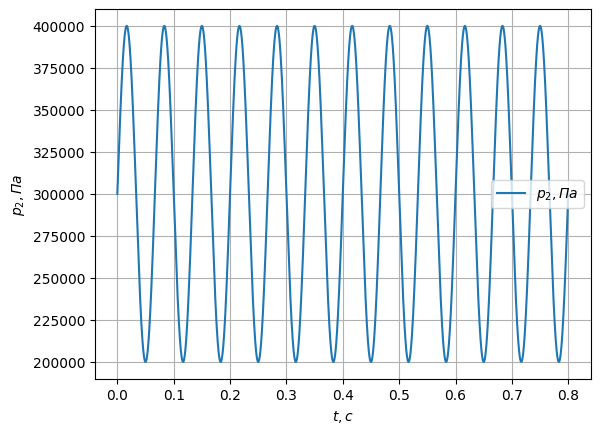

In [16]:
plot(t[:], [p2_sin_afc(t, frequancy[15]) for t in t][:], "$p_2, Па$")

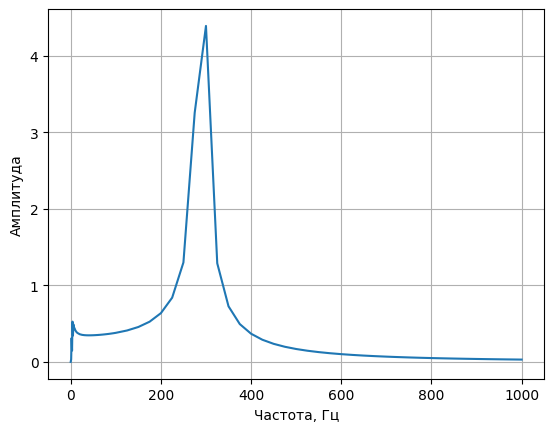

In [17]:
plt.plot(frequancy, amplitude_nodamper)
plt.grid()
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда")
plt.show()